In [1]:
import os
import sys
from scgt import GeoTiff
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/')
sys.path.append('/Users/nvalett/Documents/Natalie/Species Dist Research/Code/ecoscape-earth/ecoscape-connectivity/')
from EcoLinker.EcoLinker.restorationOptimizer import restorationOptimizer
from ecoscape_connectivity_local import repopulation, util
import matplotlib.pyplot as plt
# import ecoscape_connectivity
from scgt import Tile, GeoTiff
import numpy as np
import torch
import rasterio

DATA_PATH="/Users/nvalett/Documents/Natalie/Species Dist Research/Thesis/EcoLinker/tests/assets"
HABITAT_PATH = os.path.join(DATA_PATH, "smol/hab_smol.tif")
TERRAIN_PATH = os.path.join(DATA_PATH, "smol/terrain.tif")
RESTORED_TERRAIN_PATH = os.path.join(DATA_PATH, "smol/restored_ter_smol.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "paper_repro/transmission_refined_1.csv")
transmission_d = util.read_transmission_csv(PERMEABILITY_PATH)

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop.tif")
RESTORED_CONNECTIVITY_PATH = os.path.join(DATA_PATH, "smol/repop_after_restoration.tif")
FLOW_PATH = os.path.join(DATA_PATH, "smol/grad.tif")
RESTORED_FLOW_PATH = os.path.join(DATA_PATH, "smol/grad_after_restoration.tif")
DEATH_PATH = os.path.join(DATA_PATH, "smol/death.tif")

optimizer = restorationOptimizer(HABITAT_PATH, TERRAIN_PATH, RESTORED_TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, RESTORED_CONNECTIVITY_PATH, RESTORED_FLOW_PATH, DEATH_PATH, PERMEABILITY_PATH, 50)

In [ ]:
# set mpl params
def setup_mpl():
    plt.rcParams['font.family'] = "Helvetica Neue"
    plt.rcParams['font.size'] = 11
    plt.rcParams['figure.figsize'] = (3,3)
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['lines.linewidth'] = 1
setup_mpl()

Restoration based on highest death rates:
1. Compute connectivity with pre-determined seeds
2. Compute death layer by taking (flow/p) * (1-p)
3. Find top n pixels with highest death rates
4. Convert pixels to more permiable terrain

In [ ]:
# Pre-set seeds for determinism...
hab = GeoTiff.from_file(optimizer.habitat_fn)
hab_tile = hab.get_all_as_tile().m.astype(np.float)
seeds = (torch.rand(400,*(hab_tile.shape)) < 0.002) * hab_tile # 1% of pixels are seeds.

In [ ]:
# compute connectivity - not needed unless output is needed
repopulation.compute_connectivity(HABITAT_PATH, TERRAIN_PATH, CONNECTIVITY_PATH, FLOW_PATH, transmission_d, single_tile=True)
pre_restoration_conn = optimizer.sum_of_tif(CONNECTIVITY_PATH)

Try to compute regional connectivity gain for each restored pixel...

In [2]:
PRE_TER = os.path.join(DATA_PATH, "smol/pre_ter.tif")
PRE_HAB = os.path.join(DATA_PATH, "smol/pre_hab.tif")
PRE_CONN = os.path.join(DATA_PATH, "smol/pre_conn.tif")
PRE_FLOW = os.path.join(DATA_PATH, "smol/pre_flow.tif")
POST_TER = os.path.join(DATA_PATH, "smol/post_ter.tif")
POST_HAB = os.path.join(DATA_PATH, "smol/post_hab.tif")
POST_CONN = os.path.join(DATA_PATH, "smol/post_conn.tif")
POST_FLOW = os.path.join(DATA_PATH, "smol/post_flow.tif")

In [9]:
death_tif = optimizer.get_death_layer(optimizer.death_fn)
highest_pixels, highest_death = optimizer.get_highest_death_pixels_island(death_tif, n=50)
print(f"highest_pixels: {highest_pixels}")
print(f"highest_death: {highest_death}")

ter = GeoTiff.from_file(optimizer.terrain_fn)
restored_ter = GeoTiff.from_file(optimizer.restored_terr_fn)
hab = GeoTiff.from_file(optimizer.habitat_fn)

window_sz = 16

total_delta_connectivity = 0
total_percent_change = 0.0

permeabilities = []
deaths = []
change_percents = []

for y, x in highest_pixels:
    print(f"x: {x} y: {y}")
    deaths.append(death_tif.get_pixel_value(x, y))
    lat_max, lon_max = rasterio.transform.xy(ter.dataset.transform, y-window_sz, x-window_sz)
    lat_min, lon_min = rasterio.transform.xy(ter.dataset.transform, y+window_sz, x+window_sz)

    pre_ter = ter.crop_to_new_file(PRE_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # pre_ter.draw_geotiff()
    pre_ter.dataset.close()

    pre_hab = hab.crop_to_new_file(PRE_HAB, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # hab_tile = hab.get_all_as_tile().m.astype(np.float)
    # pre_hab.draw_geotiff()
    pre_hab.dataset.close()

    # seed = torch.randint(1, 1000, (1,))[0]
    # seed = i
    repopulation.compute_connectivity(PRE_HAB, PRE_TER, PRE_CONN, PRE_FLOW, transmission_d, single_tile=True, num_simulations=5000)

    # conn_before = GeoTiff.from_file(PRE_CONN)
    # conn_before_tile = conn_before.get_all_as_tile()
    # conn_before.draw_geotiff()

    pre_conn_sum = optimizer.sum_of_tif(PRE_CONN)

    with GeoTiff.from_file(optimizer.terrain_fn) as terrain_geotiff:
        old_terrain = terrain_geotiff.get_pixel_value(x, y)
        permeabilities.append(optimizer.permeability_dict[old_terrain])

    optimizer.change_terrain(x, y, verbose=True)
    post_ter = restored_ter.crop_to_new_file(POST_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # post_ter.draw_geotiff()
    post_ter.dataset.close()

    repopulation.compute_connectivity(PRE_HAB, POST_TER, POST_CONN, POST_FLOW, transmission_d, single_tile=True, num_simulations=5000)
    # conn_after = GeoTiff.from_file(POST_CONN)
    # conn_after.draw_geotiff()
    # conn_after_tile = conn_after.get_all_as_tile()
    post_conn_sum = optimizer.sum_of_tif(POST_CONN)
    
    # change in connectivity:
    delta_conn = int(post_conn_sum) - int(pre_conn_sum)
    percent_change = delta_conn / pre_conn_sum

    change_percents.append(percent_change)

    total_delta_connectivity += delta_conn
    total_percent_change += percent_change

    # diff_tile = Tile(conn_after_tile.w, conn_after_tile.h, conn_after_tile.b, conn_after_tile.c, conn_after_tile.x, conn_after_tile.y, conn_after_tile.m-conn_before_tile.m)
    # diff_tile.draw_tile()

    print(f'pre-restoration sum of connectivity {pre_conn_sum}')
    print(f'post-restoration sum of connectivity {post_conn_sum}')
    print(f'change in connectivity: {delta_conn}, or {percent_change.round(7)}%')

print(f"total_delta_connectivity: {total_delta_connectivity}")
print(f"Average percent change: {total_percent_change / len(highest_pixels)}")



ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


148
x: 231 y: 193


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Restoring pixel (231, 193) from permiability 0.9091386861313868 to 1.0


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


pre-restoration sum of connectivity 9312
post-restoration sum of connectivity 9554
change in connectivity: 242, or 0.025988%
x: 231 y: 194


ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_name: /Users/nvalett/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


KeyboardInterrupt: 

[36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30]
[0.09342301943198804, -0.005649717514124294, -0.012067578439259855, -0.01183159188690842, 0.07707631014403923, -0.012588212855235552, 0.15965346534653466, 0.14894398530762168, 0.3368747233289066, 0.05357369556937921, 0.04586713792272472, 0.023066970062017578, 0.03773584905660377, 0.02447980416156671, -0.011897919301069088, -0.028686396677050884, 0.1903114186851211, 0.09640221402214022, 0.11303129378794956, 0.024243908411901556, 0.04638635343408649, 0.12890700834789362, 0.02277385561375541, 0.19407321324811155, 0.13395012067578438, 0.08050478677110531, 0.004156617232000821, -0.006474648893120685, 0.007250580046403712, -0.001545993300695697, 0.021213026590976996, 0.006197171651495448, 0.0035687642397725667, 0.04862825469281289, -0.010820797044074954, 0.014726527805632753, -0.000250935781351

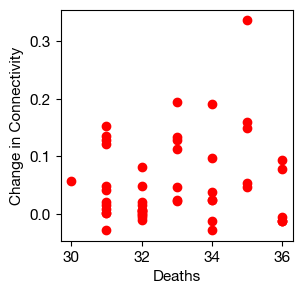

In [75]:
print(deaths)
print(change_percents)
plt.scatter(deaths, change_percents, color="red")
plt.xlabel("Deaths")
plt.ylabel("Change in Connectivity")
plt.show()

In [74]:
print(np.corrcoef(deaths, change_percents))

[[1.         0.12648271]
 [0.12648271 1.        ]]


In [72]:
death_sum = 0
for i in highest_death.values():
    death_sum += i

print(death_sum)


1646


6737/1646 = 4.093

About 4x more connectivity units per potential unit

TODO:
- Look at correlation between amount of permiability restored, and % change in connectivity
- visualize difference before -> after

In [73]:
14649/1646

8.899756986634264

Compare results to randomly chosen pixels:

In [79]:
from random import randint

# get n random (x, y) pairs in a range
def gencoordinates(width, height, n):
    seen = set()

    x, y = randint(0, width), randint(0, height)

    while len(seen) < n:
        seen.add((x, y))
        yield (x, y)
        x, y = randint(0, width), randint(0, height)
        while (x, y) in seen:
            x, y = randint(0, width), randint(0, height)

print(death_tif.width)
print(death_tif.height)

coords = gencoordinates(death_tif.width, death_tif.height, 50)
for i in coords:
    print(i)



312
218
(157, 112)
(298, 206)
(226, 128)
(136, 1)
(107, 176)
(166, 146)
(77, 216)
(225, 35)
(217, 51)
(194, 201)
(267, 22)
(178, 10)
(287, 178)
(217, 105)
(11, 115)
(310, 28)
(263, 139)
(39, 117)
(23, 47)
(307, 100)
(276, 54)
(241, 116)
(116, 90)
(185, 32)
(117, 108)
(256, 118)
(173, 87)
(41, 104)
(173, 89)
(41, 125)
(256, 167)
(90, 159)
(91, 92)
(92, 131)
(10, 99)
(117, 46)
(37, 9)
(218, 136)
(15, 208)
(49, 217)
(16, 190)
(78, 30)
(55, 143)
(277, 149)
(293, 134)
(303, 151)
(254, 161)
(101, 37)
(254, 6)
(102, 11)


In [81]:
coords = gencoordinates(death_tif.width, death_tif.height, 50)

ter = GeoTiff.from_file(optimizer.terrain_fn)
restored_ter = GeoTiff.from_file(optimizer.restored_terr_fn)
hab = GeoTiff.from_file(optimizer.habitat_fn)

window_sz = 16

total_delta_connectivity = 0
total_percent_change = 0.0

permeabilities = []
deaths = []
change_percents = []

for i, (x, y) in enumerate(coords):
    # deaths.append(highest_death[(x, y)])
    lat_max, lon_max = rasterio.transform.xy(ter.dataset.transform, y-window_sz, x-window_sz)
    lat_min, lon_min = rasterio.transform.xy(ter.dataset.transform, y+window_sz, x+window_sz)

    pre_ter = ter.crop_to_new_file(PRE_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # pre_ter.draw_geotiff()
    pre_ter.dataset.close()

    pre_hab = hab.crop_to_new_file(PRE_HAB, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # hab_tile = hab.get_all_as_tile().m.astype(np.float)
    # pre_hab.draw_geotiff()
    pre_hab.dataset.close()

    # seed = torch.randint(1, 1000, (1,))[0]
    # seed = i
    repopulation.compute_connectivity(PRE_HAB, PRE_TER, PRE_CONN, PRE_FLOW, transmission_d, single_tile=True, num_simulations=5000)

    # conn_before = GeoTiff.from_file(PRE_CONN)
    # conn_before_tile = conn_before.get_all_as_tile()
    # conn_before.draw_geotiff()

    pre_conn_sum = optimizer.sum_of_tif(PRE_CONN)

    with GeoTiff.from_file(optimizer.terrain_fn) as terrain_geotiff:
        old_terrain = terrain_geotiff.get_pixel_value(x, y)
        permeabilities.append(optimizer.permeability_dict[old_terrain])

    optimizer.change_terrain(x, y, verbose=True)
    post_ter = restored_ter.crop_to_new_file(POST_TER, [lat_max, lon_min, lat_min, lon_max], padding=0)
    # post_ter.draw_geotiff()
    post_ter.dataset.close()

    repopulation.compute_connectivity(PRE_HAB, POST_TER, POST_CONN, POST_FLOW, transmission_d, single_tile=True, num_simulations=5000)
    # conn_after = GeoTiff.from_file(POST_CONN)
    # conn_after.draw_geotiff()
    # conn_after_tile = conn_after.get_all_as_tile()
    post_conn_sum = optimizer.sum_of_tif(POST_CONN)
    
    # change in connectivity:
    delta_conn = int(post_conn_sum) - int(pre_conn_sum)
    percent_change = delta_conn / pre_conn_sum

    change_percents.append(percent_change)

    total_delta_connectivity += delta_conn
    total_percent_change += percent_change

    # diff_tile = Tile(conn_after_tile.w, conn_after_tile.h, conn_after_tile.b, conn_after_tile.c, conn_after_tile.x, conn_after_tile.y, conn_after_tile.m-conn_before_tile.m)
    # diff_tile.draw_tile()

    print(f'pre-restoration sum of connectivity {pre_conn_sum}')
    print(f'post-restoration sum of connectivity {post_conn_sum}')
    print(f'change in connectivity: {delta_conn}, or {percent_change.round(7)}%')

print(f"total_delta_connectivity: {total_delta_connectivity}")
print(f"Average percent change: {total_percent_change / len(coords)}")



Restoring pixel (15, 51) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 10930
post-restoration sum of connectivity 10986
change in connectivity: 56, or 0.0051235%
Restoring pixel (217, 210) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 8190
post-restoration sum of connectivity 8162
change in connectivity: -28, or -0.0034188%
Restoring pixel (124, 195) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 8313
post-restoration sum of connectivity 8139
change in connectivity: -174, or -0.0209311%
Restoring pixel (209, 57) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 68
post-restoration sum of connectivity 52
change in connectivity: -16, or -0.2352941%
Restoring pixel (242, 21) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 158636
post-restoration sum of connectivity 158494
change in connectivity: -142, or -0.0008951%
Restoring pixel (271, 0) from permiability 1.0 to 1.0
pre-restoration sum of connectivi

/var/folders/py/kw30nbf92q9fms5c67mmgz6m0000gn/T/ipykernel_60394/2493366834.py:57: RuntimeWarning: invalid value encountered in divide
  percent_change = delta_conn / pre_conn_sum


pre-restoration sum of connectivity 0
post-restoration sum of connectivity 0
change in connectivity: 0, or nan%
Restoring pixel (185, 111) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 29188
post-restoration sum of connectivity 29714
change in connectivity: 526, or 0.0180211%
Restoring pixel (170, 145) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 41216
post-restoration sum of connectivity 42336
change in connectivity: 1120, or 0.0271739%
Restoring pixel (201, 80) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 84128
post-restoration sum of connectivity 84029
change in connectivity: -99, or -0.0011768%
Restoring pixel (55, 42) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 91522
post-restoration sum of connectivity 92088
change in connectivity: 566, or 0.0061843%
Restoring pixel (35, 31) from permiability 1.0 to 1.0
pre-restoration sum of connectivity 81241
post-restoration sum of connectivity 82272
change in conn

TypeError: object of type 'generator' has no len()

In [88]:
total_percent_change = 0
for i in change_percents:
    if type(i) == np.float64:
        total_percent_change += i

print(total_percent_change)

print(f"total_delta_connectivity: {total_delta_connectivity}")
print(f"Average percent change: {total_percent_change / 50}")

nan
total_delta_connectivity: 5885
Average percent change: nan
